In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.segmentation import slic
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import networkx as nx

import shap

/opt/homebrew/Caskroom/miniforge/base/envs/PyTc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X, y = shap.datasets.imagenet50()

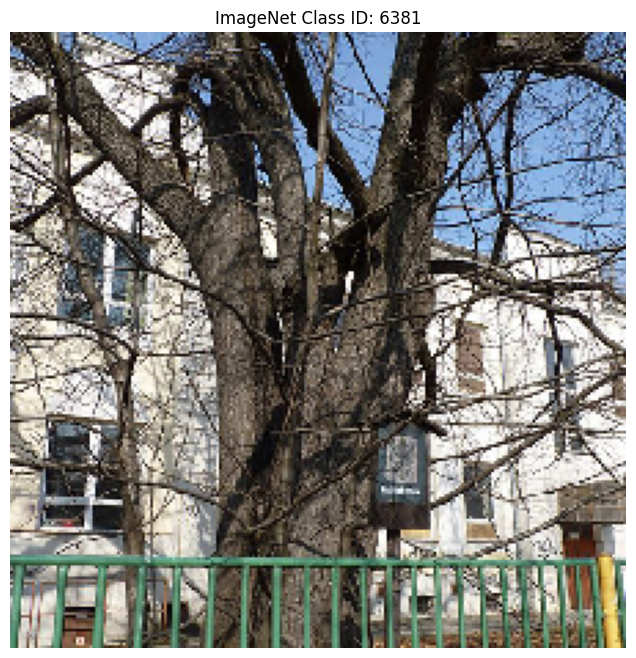

Image shape: (224, 224, 3)
Value range: Min=0.0, Max=255.0


In [3]:
# Select an image to display (index 0 in this case)
img = X[0]

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img.astype('uint8'))
plt.axis('off')
plt.title(f'ImageNet Class ID: {int(y[0])}')
plt.show()

# Print image shape information
print(f"Image shape: {img.shape}")
print(f"Value range: Min={img.min()}, Max={img.max()}")

In [4]:
if img.shape[-1] == 4:
    img = img[..., :3]  # 如果是RGBA，去掉透明度通道

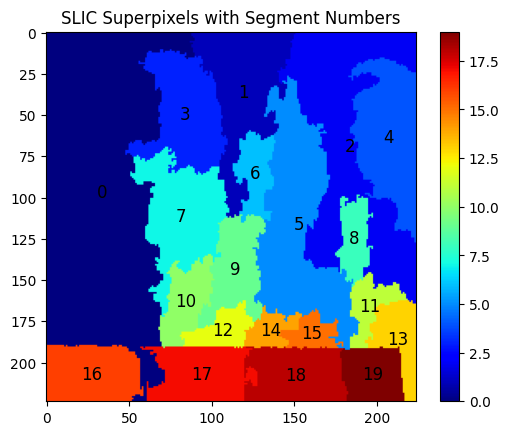

In [5]:
# 2. 超像素分割
n_segments = 100  # 超像素数量可以调
segments = slic(img, n_segments=n_segments, compactness=10, start_label=0)

# Plot the superpixels with their corresponding segment numbers
plt.imshow(segments, cmap='jet')
plt.title('SLIC Superpixels with Segment Numbers')
plt.colorbar()

# Annotate each segment with its number
for seg_val in np.unique(segments):
    mask = (segments == seg_val)
    coords = np.column_stack(np.where(mask))
    if len(coords) > 0:
        centroid_y, centroid_x = np.mean(coords, axis=0)
        plt.text(centroid_x, centroid_y, str(seg_val), color='black', fontsize=12, ha='center', va='center')

plt.show()

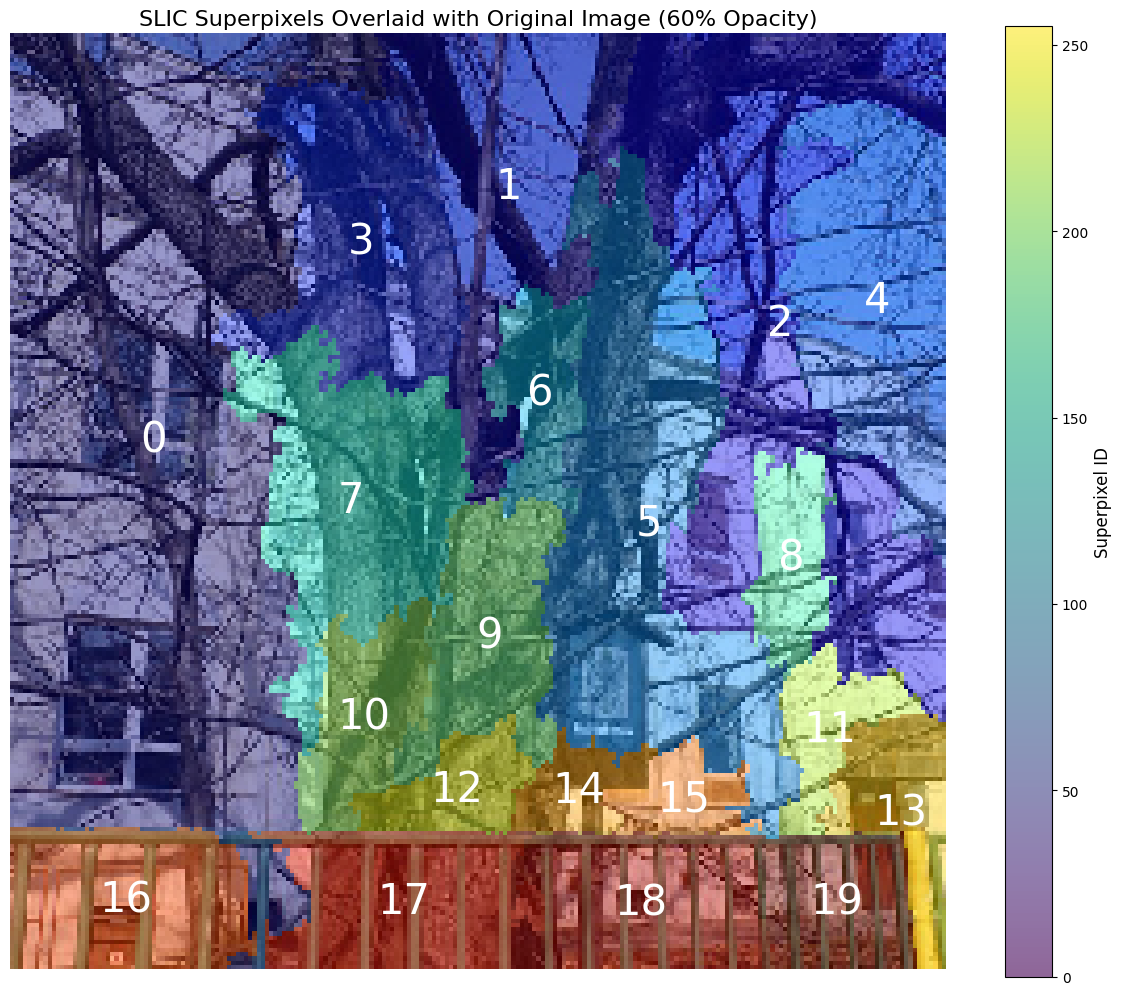

In [6]:
# Create a visualization with the original image overlaid on the segmentation map
plt.figure(figsize=(12, 10))

# First show the segmentation map (superpixels)
plt.imshow(segments, cmap='jet')

# Overlay the original image with transparency
plt.imshow(img.astype('uint8'), alpha=0.6)  # Set transparency to 0.6

# Add a title
plt.title('SLIC Superpixels Overlaid with Original Image (60% Opacity)', fontsize=16)

# Add a colorbar for the segmentation
cbar = plt.colorbar()
cbar.set_label('Superpixel ID', fontsize=12)
# Annotate each segment with its number
for seg_val in np.unique(segments):
    mask = (segments == seg_val)
    coords = np.column_stack(np.where(mask))
    if len(coords) > 0:
        centroid_y, centroid_x = np.mean(coords, axis=0)
        plt.text(centroid_x, centroid_y, str(seg_val), color='white', fontsize=30, ha='center', va='center')
plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

In [7]:
# 3. 每个超像素提取特征（均值颜色+简单纹理）
features = []
for seg_val in np.unique(segments):
    mask = (segments == seg_val)
    
    # 1. 颜色特征
    mean_color = np.mean(img[mask], axis=0)  # RGB均值 (3维)
    std_color = np.std(img[mask], axis=0)    # RGB标准差 (3维)
    
    # 2. 形状和空间特征
    coords = np.column_stack(np.where(mask))
    
    if len(coords) > 0:
        # 位置信息 - 质心 (2维)
        centroid_y, centroid_x = np.mean(coords, axis=0)
        
        # 面积 (1维)
        area = len(coords)
        
        # 边界框尺寸 (2维)
        minr, minc = coords.min(axis=0)
        maxr, maxc = coords.max(axis=0)
        height = maxr - minr + 1
        width = maxc - minc + 1
        
        # 3. 纹理特征
        gray = color.rgb2gray(img)
        region = gray[minr:maxr+1, minc:maxc+1]
        region_masked = np.zeros_like(region)
        local_mask = mask[minr:maxr+1, minc:maxc+1]
        
        if local_mask.size > 0 and np.any(local_mask):
            region_masked[local_mask] = region[local_mask]
            # GLCM特征 (4维)
            try:
                glcm = graycomatrix((region_masked * 255).astype(np.uint8), 
                                   distances=[1], angles=[0], 
                                   levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                # 相关性可能会出现NaN，所以需要处理这种情况
                try:
                    correlation = graycoprops(glcm, 'correlation')[0, 0]
                    if np.isnan(correlation):
                        correlation = 0.0
                except:
                    correlation = 0.0
            except:
                # 如果GLCM计算失败，使用默认值
                contrast = dissimilarity = homogeneity = energy = correlation = 0.0
                
            # 像素值统计 (2维)
            if np.any(local_mask):
                pixel_mean = np.mean(region[local_mask])
                pixel_std = np.std(region[local_mask])
            else:
                pixel_mean = pixel_std = 0.0
        else:
            # 默认纹理特征值
            contrast = dissimilarity = homogeneity = energy = correlation = 0.0
            pixel_mean = pixel_std = 0.0
            
        # 汇总所有特征，确保维度一致
        feature_vector = np.hstack([
            mean_color,                  # RGB均值 (3维)
            std_color,                   # RGB标准差 (3维)
            [centroid_y, centroid_x],    # 质心坐标 (2维)
            [area],                      # 面积 (1维)
            [height, width],             # 边界框尺寸 (2维)
            [contrast, dissimilarity, homogeneity, energy, correlation],  # 纹理特征 (5维)
            [pixel_mean, pixel_std]      # 像素统计 (2维)
        ])
        # 检查确保没有NaN值
        feature_vector = np.nan_to_num(feature_vector, nan=0.0)
    else:
        # 如果没有足够的像素，填充默认值
        # 总共18维特征
        feature_vector = np.zeros(18)
    
    features.append(feature_vector)

features = np.array(features).T

In [8]:
labels = [i for i in range(features.shape[1])]

# 标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 4. 因果推断（PC算法）
# PC算法要求输入的是变量在不同样本下的取值，这里我们反过来直接当特征点彼此独立的小样本来建图
# 这里只是示意用，实际要考虑更多数据的话需要采样更多patch
causal_graph = pc(features_scaled, independence_test_method='fisherz', alpha=0.2)

print(causal_graph.G)

/opt/homebrew/Caskroom/miniforge/base/envs/PyTc/lib/python3.12/site-packages/causallearn/search/ConstraintBased/PC.py:36: UserWarning: The number of features is much larger than the sample size!
  warnings.warn("The number of features is much larger than the sample size!")
Depth=2, working on node 19: 100%|██████████| 20/20 [00:00<00:00, 98.38it/s]  

Graph Nodes:
X1;X2;X3;X4;X5;X6;X7;X8;X9;X10;X11;X12;X13;X14;X15;X16;X17;X18;X19;X20

Graph Edges:
1. X3 --- X6
2. X7 --- X11
3. X7 --- X20
4. X9 --- X16
5. X15 --> X13
6. X20 --> X13
7. X14 --> X19
8. X17 --- X18
9. X18 --> X19



In [9]:
# Build a NetworkX graph from the adjacency matrix
def build_nx_graph(causal_graph, labels):
    import networkx as nx
    G = nx.DiGraph()
    num_nodes = len(labels)
    G.add_nodes_from(range(num_nodes))
    # Add edges based on causal graph structure
    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_type = causal_graph.G.graph[i][j]
            if edge_type == 1: # Directed edge from i to j
                G.add_edge(j, i)
            elif edge_type == -1: # Directed edge from j to i
                G.add_edge(i, j)
            elif edge_type == 2: # Undirected edge
                G.add_edge(i, j)
                G.add_edge(j, i)
    # Relabel nodes with variable names
    mapping = {i: label for i, label in enumerate(labels)}
    G = nx.relabel_nodes(G, mapping)
    return G

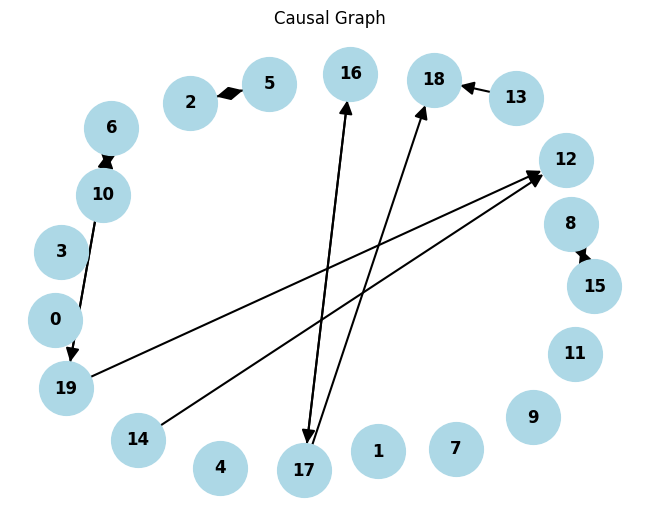

In [14]:
G = build_nx_graph(causal_graph, labels)

# Plot the causal graph
pos = nx.spring_layout(G, k=4.0)  # k parameter increases the spacing between nodes
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1500,
    node_color='lightblue',
    arrowsize=20,
    font_size=12,
    font_weight='bold',
    arrows=True,
    width=1.5  # Increase edge width for better visibility
)
plt.title('Causal Graph')
plt.show()